In [1]:
import tensorflow as tf
from nn_class import DenseNetwork, DeepONet
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas as pd

2025-10-16 23:35:38.519622: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760650538.549374   87774 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760650538.559264   87774 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# DeepONet architecture
We would like to approximate the normal derivative of the potential of the electric field with a DeepONet architecture. \
The branch net has 3 input parameter, the geometric parameters: overetch, distance, angle, which define the mesh;\
The trunk net has 1 input parameter, the curvilnear absissa, and 1 output, the value of the electric field.

In [2]:
# Reproducibility setup --------------------------------------------------------
np.random.seed(1)
tf.random.set_seed(1)
tf.keras.utils.set_random_seed(1)

# Hyperparameters setup --------------------------------------------------------
r = 20     # low-rank dimension
p = 3      # number of problem parameters = geometrical parameters
d = 1      # number of spatial dimensions
ns = 1000  # number of samples = number of meshes
nh = 350   # number of dofs = x-coordinates available for each mesh

# Training setup ---------------------------------------------------------------
epochs = 1000
batch_size = 3

# Data --------------------------------------------------------------
data_csv = pd.read_csv('../data/unrolled_normal_derivative_potential.csv')
mu_data = data_csv.iloc[:, 1:4] # geometrical parameters
mu_data = np.array(mu_data)
#Now we have to reshape mu_data to be ns x p (remove duplicates)
mu_data = mu_data[::nh, :]
x_data = data_csv.iloc[:, 4]    # x-coordinates
x_data = np.array(x_data)
#Now we have to reshape x_data to be ns x nh x d
x_data = x_data.reshape((ns, nh, d))
u_data = data_csv.iloc[:, 5]    # solution at x-coordinates
u_data = np.array(u_data)
#Now we have to reshape u_data to be ns x nh
u_data = u_data.reshape((ns, nh))
print(mu_data.shape) # should be ns x p
print(x_data.shape) # should be ns x nh x d
print(u_data.shape) # should be ns x nh

(1000, 3)
(1000, 350, 1)
(1000, 350)


In [ ]:
# Network construction
branch = DenseNetwork(
    width = 20,
    depth = 3,
    output_dim = r, 
    input_dim = p, 
    activation = 'relu'
    )
trunk = DenseNetwork(
    width = 20,
    depth = 4,
    output_dim = r,
    input_dim = d,
    activation = 'relu'
)
deeponet = DeepONet(branch, trunk)

# Checking implementation correctness (should be ns x nh)
print(deeponet((mu_data, x_data)).shape)    # if the samples have different spatial points in which they are evaluated
print(deeponet((mu_data, x_data[0])).shape) # if the samples have the same spatial points

I0000 00:00:1760650549.690129   87774 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6102 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060 SUPER, pci bus id: 0000:0a:00.0, compute capability: 7.5
W0000 00:00:1760650550.843257   88091 gpu_backend_lib.cc:579] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  /home/ale/anaconda3/envs/pacs/nvvm/libdevice
  ipykernel_launcher.runfiles/cuda_nvcc
  ipykern/cuda_nvcc
  
  /usr/local/cuda
  /home/ale/anaconda3/envs/pacs/lib/python3.10/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc
  /home/ale/anaconda3/envs/pacs/lib/python3.10/site-packages/tensorflow/python/platform/../../../../nvidia/cuda_nvcc
  /home/ale/anaconda3/envs/pacs/lib/python3.10/site-packages/tensorflow/python/platform/../../cuda
  .
You can choose th

(1000, 350)
(1000, 350)


Model: "deep_o_net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_network (DenseNetwork)    │ ?                      │           920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_network_1 (DenseNetwork)  │ ?                      │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,220 (8.67 KB)

 Trainable params: 2,220 (8.67 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# Data splitting
ns_train = ns // 2
ns_test = ns // 4
mu_train, mu_val, mu_test = mu_data[:ns_train], mu_data[ns_train:-ns_test], mu_data[-ns_test:]
x_train, x_val, x_test = x_data[:ns_train], x_data[ns_train:-ns_test], x_data[-ns_test:]
u_train, u_val, u_test = u_data[:ns_train], u_data[ns_train:-ns_test], u_data[-ns_test:]

In [ ]:
# Training
deeponet.compile(optimizer = 'adam', loss = 'mse')
deeponet.fit(
    x = [mu_train, x_train],
    y = u_train,
    validation_data = ([mu_val, x_val], u_val),
    epochs = epochs,
    batch_size = batch_size
)

Epoch 1/10


I0000 00:00:1760650583.519574   88054 service.cc:148] XLA service 0x7dd9c4005940 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760650583.519622   88054 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2060 SUPER, Compute Capability 7.5
2025-10-16 23:36:23.599835: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1760650583.863927   88054 cuda_dnn.cc:529] Loaded cuDNN version 91300


 48/167 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13938.4746

I0000 00:00:1760650584.994047   88054 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 1637.1449 - val_loss: 342.5189
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 61.9256 - val_loss: 158.3412
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 26.2010 - val_loss: 91.2331
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 11.4368 - val_loss: 46.8391
Epoch 5/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.6156 - val_loss: 25.6596
Epoch 6/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.0419 - val_loss: 14.3949
Epoch 7/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.6589 - val_loss: 9.6918
Epoch 8/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.9375 - val_loss: 7.3432
Epoch 9/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.2102 - val_loss: 6.4431
Epoch 10/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7345 - val_loss: 5.6232


In [8]:
# To save model
deeponet.save("../models/deeponet_model_relu.keras")

# To load existing model
import keras

loaded_mod = keras.models.load_model(
    "../models/deeponet_model_relu.keras",
    custom_objects={"DeepONet": DeepONet, "DenseNetwork": DenseNetwork}
)


/home/ale/anaconda3/envs/pacs/lib/python3.10/site-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'dense_network', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/home/ale/anaconda3/envs/pacs/lib/python3.10/site-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'dense_network_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


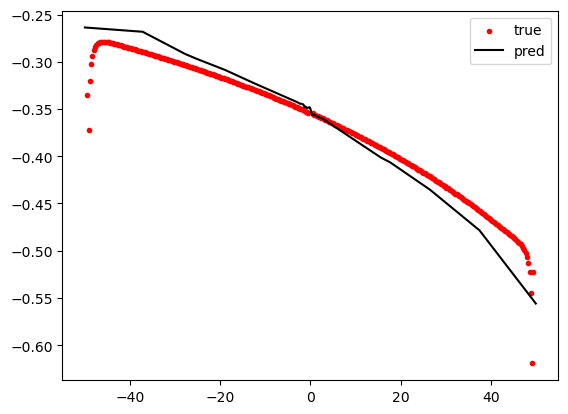

In [180]:
# Visualizing a test sample and its approximation using deeponets
#Set seed for reproducibility
np.random.seed(99)
# index of the test sample (= combination of geometric parameters) to plot
idx_plot = np.random.randint(0, mu_test.shape[0]) 
# number of points in which to evaluate the solution
points = 1000 
x_lin = np.linspace(-50, 50, points)[:,None]
u_pred_test = deeponet([mu_test, x_lin])
plt.figure()
plt.scatter(x_test[idx_plot], u_test[idx_plot], marker = '.', color = 'r', label = 'true')
plt.plot(x_lin, u_pred_test[idx_plot], 'k-', label = 'pred')
plt.legend();  # Added semicolon to suppress memory location output

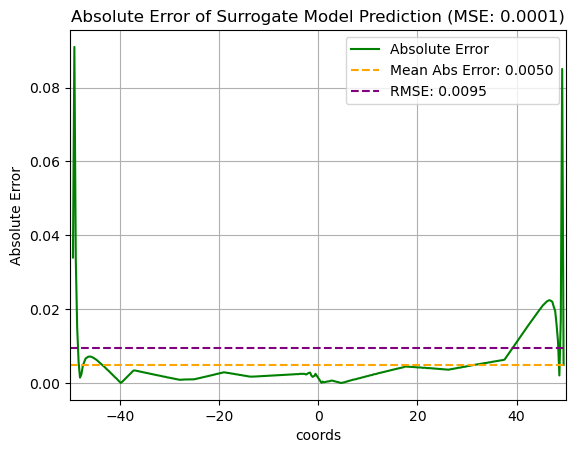

In [179]:
# Error visualization
# Plot the absolute difference between prediction and true values
coords = x_test[idx_plot] 
u = u_test[idx_plot]
u_pred = (deeponet([mu_test, coords]))[idx_plot]
abs_diff = np.abs(u - u_pred)
mse = np.mean((u - u_pred) ** 2)
plt.figure(2)
coords = coords.reshape(-1) #remove second dimension
plt.plot(coords, abs_diff, label="Absolute Error", color="green")
plt.xlim(-50, 50)
plt.xlabel("coords")
plt.ylabel("Absolute Error")
plt.title(f"Absolute Error of Surrogate Model Prediction (MSE: {mse:.4f})")
mean_abs_error = np.mean(abs_diff)
plt.axhline(mean_abs_error, color="orange", linestyle="--", label=f"Mean Abs Error: {mean_abs_error:.4f}")
plt.axhline(np.sqrt(mse), color="purple", linestyle="--", label=f"RMSE: {np.sqrt(mse):.4f}")
plt.legend()
plt.grid(True)
plt.show()